# Preprocessing, k-Nearest Neighbors (Bill Lee)

# Support Vector Machine (Lester Fan)

# k-Means Clustering (Anton Maliev)

### Preprocessing

In [5]:
import numpy as np
from matplotlib import pyplot as plt 
import glob
from skimage.io import imread

daisy,dandelion,rose,sunflower,tulip = [],[],[],[],[]

for filename in glob.glob('flowerscomp2/daisy/*.jpg'): # for daisies
    im = imread(filename,True).flatten()
    daisy.append(im)    

for filename in glob.glob('flowerscomp2/dandelion/*.jpg'): # for dandelion
    im = imread(filename,True).flatten()
    dandelion.append(im)
    
for filename in glob.glob('flowerscomp2/rose/*.jpg'): # for roses
    im = imread(filename,True).flatten()
    rose.append(im)
    
for filename in glob.glob('flowerscomp2/sunflower/*.jpg'): # for sunflowers
    im = imread(filename,True).flatten()
    sunflower.append(im)
    
for filename in glob.glob('flowerscomp2/tulip/*.jpg'): # for tulip
    im = imread(filename,True).flatten()
    tulip.append(im)

In [6]:
daisy_arr=np.asarray(daisy)
dandelion_arr=np.asarray(dandelion)
rose_arr=np.asarray(rose)
sunflower_arr=np.asarray(sunflower)
tulip_arr=np.asarray(tulip)

# daisy = 0, dandelion = 1, rose = 2, sunflower = 3, tulip = 4
daisy_labels=np.zeros((len(daisy_arr),1))
dandelion_labels=np.ones((len(dandelion_arr),1))
rose_labels=2*np.ones((len(rose_arr),1))
sunflower_labels=3*np.ones((len(sunflower_arr),1))
tulip_labels=4*np.ones((len(tulip_arr),1))


# Here are the labels and the dataset 
labels=np.vstack((daisy_labels,dandelion_labels,rose_labels,sunflower_labels,tulip_labels))
dataset=np.vstack((daisy_arr,dandelion_arr,rose_arr,sunflower_arr,tulip_arr))

### PCA on Dataset

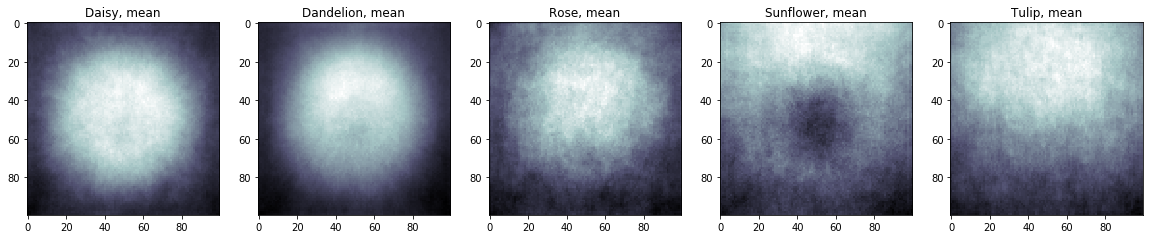

In [7]:
# means of the photos
fig=plt.figure(figsize=(20, 20))
fig.add_subplot(1,5,1)
plt.imshow(np.reshape(daisy_arr.mean(0),(100,100)),cmap='bone')
plt.title("Daisy, mean")
fig.add_subplot(1,5,2)
plt.imshow(np.reshape(dandelion_arr.mean(0),(100,100)),cmap='bone')
plt.title("Dandelion, mean")
fig.add_subplot(1,5,3)
plt.imshow(np.reshape(rose_arr.mean(0),(100,100)),cmap='bone')
plt.title("Rose, mean")
fig.add_subplot(1,5,4)
plt.imshow(np.reshape(sunflower_arr.mean(0),(100,100)),cmap='bone')
plt.title("Sunflower, mean")
fig.add_subplot(1,5,5)
plt.imshow(np.reshape(tulip_arr.mean(0),(100,100)),cmap='bone')
plt.title("Tulip, mean");

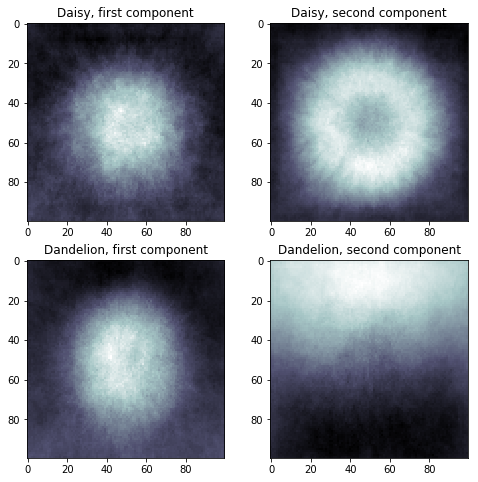

In [8]:
# Printing top principal components 
fig=plt.figure(figsize=(8,8))
centered_daisy = daisy_arr.T-np.reshape(daisy_arr.T.mean(1),(10000,1))
centered_dandelion = dandelion_arr.T-np.reshape(dandelion_arr.T.mean(1),(10000,1))
u1,s1,v1 = np.linalg.svd(centered_daisy)
u2,s2,v2 = np.linalg.svd(centered_dandelion)
component1,component2 = u1[:,[0]],u1[:,[1]]
component3,component4 = u2[:,[0]],u2[:,[1]]
fig.add_subplot(221)
plt.imshow(np.reshape(component1,(100,100)),cmap='bone')
plt.title("Daisy, first component")
fig.add_subplot(222)
plt.imshow(np.reshape(component2,(100,100)),cmap='bone')
plt.title("Daisy, second component");
fig.add_subplot(223)
plt.imshow(np.reshape((component3),(100,100)),cmap='bone')
plt.title("Dandelion, first component")
fig.add_subplot(224)
plt.imshow(np.reshape((component4),(100,100)),cmap='bone')
plt.title("Dandelion, second component");


In [12]:
# Centering the dataset 
mean=np.reshape(dataset.T.mean(1),(len(dataset.T),1))
centered=dataset.T-mean

i = 0
stds = [np.std(row) for row in centered]
normalized_samples=[]
for row in centered:
    normalized_samples.append(row/stds[i])
    i+=1

# Here I used centered to mean centered and normalized
centered = np.asarray(normalized_samples)

U,S,V=np.linalg.svd(centered)

# Determining Variation
total_s = 0
fnorm = np.linalg.norm(centered,'fro')
for k in range(2,12):
    total_s += S[k]**2
    print(k,(total_s/fnorm**2)*100)


2 6.217663060996357
3 9.842658987696309
4 12.070532853655273
5 14.0697512600888
6 15.73170983913568
7 17.325019309022416
8 18.776954766560777
9 19.793887733860853
10 20.749552653180743
11 21.60718208411161


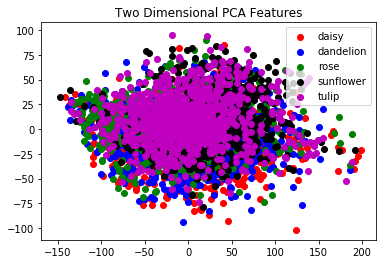

In [38]:
# Visualization of the datapoints 


p2c = (U[:,[0,1]].T@centered).T
points = [p2c[0:768],p2c[768:1820],p2c[1820:2603],p2c[2603:3337],p2c[3337:4321]]
colors = ['r','b','g','k','m']
which_flower = ['daisy','dandelion','rose','sunflower','tulip']
fig = plt.figure()

for i in range(5):
    x,y = points[i][:,0], points[i][:,1]
    plt.scatter(x,y,c=colors[i],label=which_flower[i])
plt.title('Two Dimensional PCA Features')
plt.legend(loc='upper right');

In [29]:
finalTopk=U[:,0:10]
new_dataset=finalTopk.T@centered

def scramble(samples,labels):
    fix_labels=np.reshape(labels,(1,labels.shape[0]))
    mashed = np.vstack((samples,fix_labels)).T
    np.random.shuffle(mashed)
    labels_out = mashed.T[mashed.T.shape[0]-1]
    samples_out = mashed.T[0:mashed.T.shape[0]-1]
    return [samples_out,labels_out]
    
workable_samples, workable_labels = scramble(new_dataset,labels)

In [35]:
from heapq import heappush, heappop
from scipy import stats

def kNN(k,testset,testlabels,trainset,trainlabels):
    # distance stores threeple (euclidan distance, training class, actual test class)
    confusion = np.zeros((5,5))
    for i in range(len(testset)):
        distances = []
        for j in range(len(trainset)):
            heappush(distances,(np.linalg.norm(testset[i]-trainset[j]),trainlabels[j]))
    
        # now take the k nearest
        tally = []
        for near in range(k):
            tally.append(heappop(distances)[1])
        
        winner = int(stats.mode(tally)[0])
        confusion[int(testlabels[i])][winner] += 1
    
    return confusion
        

def fiveFoldCV(data,labels):
    mega_confusion=[]
    for k in range(5,10,2):
        total_confusion = np.zeros((5,5))
        for i in range(5):
            sindex1 = (i*864)
            sindex2 = 4321 if i==4 else (i+1)*864
            test_set = data[sindex1:sindex2]
            test_labels = labels[sindex1:sindex2]
            training_set = np.concatenate((data[sindex2:4321],data[0:sindex1]))
            training_labels = np.concatenate((labels[sindex2:4321],labels[0:sindex1]))
            temp_confusion = kNN(k, test_set, test_labels, training_set, training_labels)
            total_confusion += temp_confusion
        mega_confusion.append(total_confusion)
        
    return mega_confusion
 
mega_confusion = fiveFoldCV(workable_samples.T,workable_labels)


In [36]:
for i in range(len(mega_confusion)):
    print("k (nearest neighbors)",((2*(i+1))+1),"with confusion matrix\n",mega_confusion[i])

k (nearest neighbors) 3 with confusion matrix
 [[203. 319.  67.  66. 113.]
 [187. 506.  96. 132. 131.]
 [121. 246. 155.  86. 175.]
 [ 71. 202.  59. 251. 151.]
 [104. 225. 134. 176. 345.]]
k (nearest neighbors) 5 with confusion matrix
 [[175. 338.  62.  73. 120.]
 [174. 518.  94. 117. 149.]
 [100. 256. 148.  85. 194.]
 [ 74. 186.  42. 257. 175.]
 [ 88. 224. 118. 166. 388.]]
k (nearest neighbors) 7 with confusion matrix
 [[160. 343.  60.  74. 131.]
 [144. 514.  85. 131. 178.]
 [ 76. 260. 146.  90. 211.]
 [ 59. 189.  36. 280. 170.]
 [ 63. 227. 107. 175. 412.]]


In [37]:
k = 3
for matrix in mega_confusion:
    correct = 0
    total = 0
    for i in range(5):
        for j in range(5):
            if(i==j):
                correct+=matrix[i][j]
            total += matrix[i][j]
    print(k, "with correct classification percentage", (correct/total)*100)
    k += 2
                            

3 with correct classification percentage 33.78847489007174
5 with correct classification percentage 34.390187456607265
7 with correct classification percentage 34.99190002314279
